In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

assumptions : intestinal - N is relativley stable otherwise cancer.

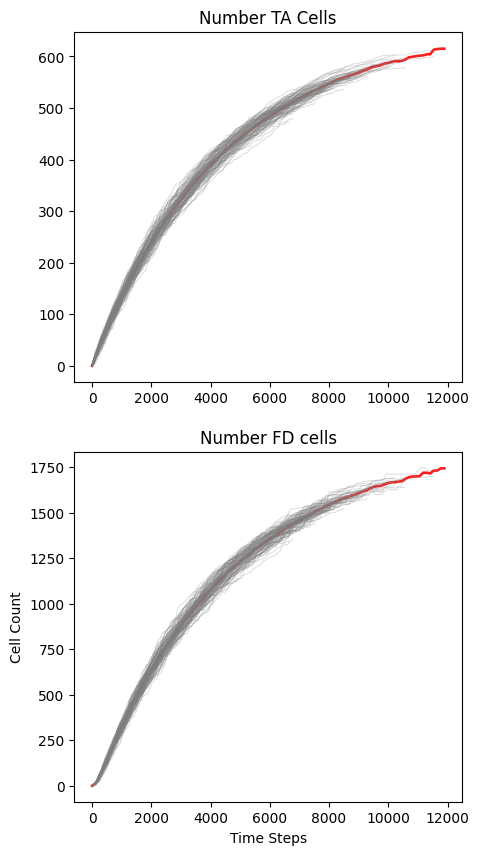

In [3]:

# Initialize variables

# Convert all rates to per hour
N0 = 18 # constant stem cell number
r = 1 / (2.5 * 24) # stem cell division rate (per hour)
lam = 1 / 30 # TA cell division rate (per hour)
d = 0.0338 # TA differentiation rate (per hour)
gamma = 1 / (3.5 * 24) # FD cell apoptosis rate (per hour)

steps = 1100   # Number of reactions per trajectory
cycles = 100   # Number of trajectories
T = np.zeros((cycles, steps + 1))  # Time array

mTA = np.zeros((cycles, steps + 1))  # Trajectory for m_TA
mFD = np.zeros((cycles, steps + 1))  # Trajectory for m_FD

# Store initial conditions (can be customized later)
mTA[:, 0] = 0  # Initial m_TA
mFD[:, 0] = 0  # Initial m_FD

# Main simulation loop
for i in range(cycles):
    for j in range(steps):
        # Calculate updated overall reaction rate based on ODE for mTA
        dmTA_dt = r * N0 + (lam - d) * mTA[i, j]
        dmFD_dt = d * mTA[i, j] - gamma * mFD[i, j]
        
        R = abs(dmTA_dt)  # Ensure reaction rate is positive

        # Calculate time to next reaction
        u1 = np.random.random()
        tau = 1 / R * np.log(1 / u1)

        # Store reaction time
        T[i, j + 1] = T[i, j] + tau

        # Select which reaction to occur
        u2 = np.random.random()
        if u2 < 0.5:  # Assign probability to modify m_TA
            mTA[i, j + 1] = mTA[i, j] + dmTA_dt * tau
            mFD[i, j + 1] = mFD[i, j]  # m_FD remains constant in this case

        else:  # Modify m_FD based on dmFD_dt
            mFD[i, j + 1] = mFD[i, j] + dmFD_dt * tau
            mTA[i, j + 1] = mTA[i, j]  # m_TA remains constant in this case

        mTA[i, j + 1] = max(0, mTA[i, j + 1])
        mFD[i, j + 1] = max(0, mFD[i, j + 1])

# # Calculate an average trajectory plot
ave_steps = 100
T_max = T.max()

# Set up average arrays
T_ave = np.linspace(0,T_max,ave_steps+1)
N_TA_ave = np.zeros(ave_steps+1)
N_FD_ave = np.zeros(ave_steps+1)

N_TA_ave[0] = 0
N_FD_ave[0] = 0

## Pass over average array entries
for i in range(1, ave_steps + 1):
    tmax = T_ave[i]
    TA_sum = 0
    FD_sum = 0
    t_count = 0

    # Pass over each trajectory and step therein
    for j in range(cycles):
        for k in range(steps):
            if T[j, k] <= tmax and T[j, k + 1] > tmax:
                t_count += 1
                TA_sum += mTA[j, k]
                FD_sum += mFD[j, k]

    # Calculate average - taking care if no samples observed
    if t_count == 0:
        N_TA_ave[i] = N_TA_ave[i - 1]
        N_FD_ave[i] = N_FD_ave[i - 1]
    else:
        N_TA_ave[i] = TA_sum / t_count
        N_FD_ave[i] = FD_sum / t_count

# ###### Plot Trajectories ######
fig, axs = plt.subplots(2, 1, figsize=(5,10))

# Plot average trajectories
axs[0].plot(T_ave, N_TA_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number TA Cells')
axs[1].plot(T_ave, N_FD_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number FD cells')

# Plot each simulated trajectory
for i in range(cycles):
    axs[0].plot(T[i,:], mTA[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    plt.xlabel("Time Steps")
    plt.ylabel("Cell Count")    
    axs[1].plot(T[i,:], mFD[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    plt.xlabel("Time Steps")
    plt.ylabel("Cell Count")


plt.show()



gillespie NO

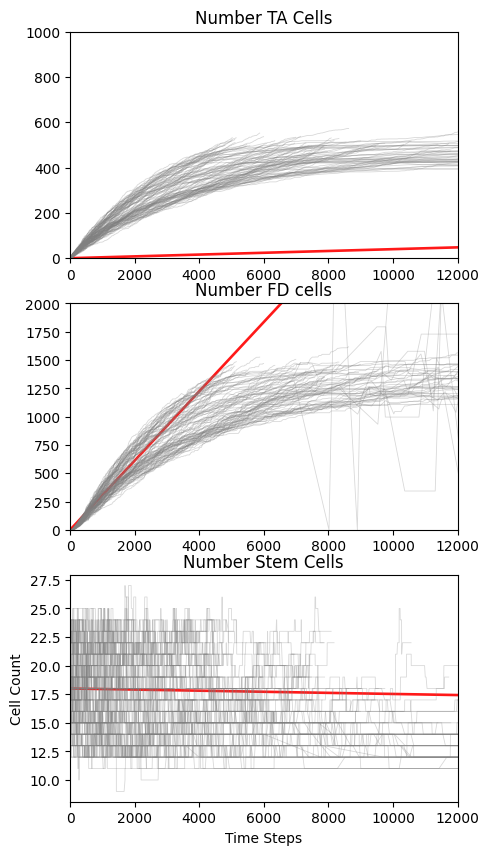

In [16]:

# Initialize variables

# Convert all rates to per hour
N_count = 18 # constant stem cell number
r = 1 / (2.5 * 24) # stem cell division rate (per hour)
lam = 1 / 30 # TA cell division rate (per hour)
d = 0.0338 # TA differentiation rate (per hour)
gamma = 1 / (3.5 * 24) # FD cell apoptosis rate (per hour)

steps = 1000   # Number of reactions per trajectory
cycles = 100   # Number of trajectories
T = np.zeros((cycles, steps + 1))  # Time array

mTA = np.zeros((cycles, steps + 1))  # Trajectory for m_TA
mFD = np.zeros((cycles, steps + 1))  # Trajectory for m_FD
Stem_Cell_Count = np.zeros((cycles, steps + 1))  # Trajectory for m_FD

# Store initial conditions (can be customized later)
mTA[:, 0] = 0  # Initial m_TA
mFD[:, 0] = 0  # Initial m_FD
Stem_Cell_Count[:, 0] = 18

def get_N(N_count):
    
    a = np.random.uniform(0.025, 0.05)

    if N_count < 13 :
        N_post_birth = np.random.binomial(n = N_count, p = a)
        N_new = N_count + N_post_birth
        N_count = N_new

        return(N_new)
    elif N_count > 23:
        N_post_death = np.random.binomial(n = N_count, p = a)
        N_new = N_count -N_post_death
        N_count = N_new

        return(N_new)
    #stochastically varries N0, this takes into account the births and deaths
    #of stem cells

    n_grow = np.random.randint(1, N_count)
    n_die = N_count - n_grow

    N_post_birth = np.random.binomial(n = n_grow, p = a)
    N_post_death = np.random.binomial(n = n_die, p = a)
   
    N_new = N_count + N_post_birth - N_post_death
    N_count = N_new

    return(N_new)


# Main simulation loop
for i in range(cycles):
    for j in range(steps):

        #generates possible change in Stem Cell Count
        p = np.random.random()
        if p < 0.1:
            N_count = get_N(Stem_Cell_Count[i, j])


        # Calculate updated overall reaction rate based on ODE for mTA
        dmTA_dt = r * N_count + (lam - d) * mTA[i, j]
        dmFD_dt = d * mTA[i, j] - gamma * mFD[i, j]
        
        R = abs(dmTA_dt)  # Ensure reaction rate is positive

        # Calculate time to next reaction
        u1 = np.random.random()
        tau = 1 / R * np.log(1 / u1)

        # Store reaction time
        T[i, j + 1] = T[i, j] + tau

        # Select which reaction to occur
        u2 = np.random.random()
        if u2 < 0.5:  # Assign probability to modify m_TA
            mTA[i, j + 1] = mTA[i, j] + dmTA_dt * tau
            mFD[i, j + 1] = mFD[i, j]  # m_FD remains constant in this case

        else:  # Modify m_FD based on dmFD_dt
            mFD[i, j + 1] = mFD[i, j] + dmFD_dt * tau
            mTA[i, j + 1] = mTA[i, j]  # m_TA remains constant in this case

        mTA[i, j + 1] = max(0, mTA[i, j + 1])
        mFD[i, j + 1] = max(0, mFD[i, j + 1])
        Stem_Cell_Count[i, j+1] = N_count

# # Calculate an average trajectory plot
ave_steps = 100
T_max = T.max()

# Set up average arrays
T_ave = np.linspace(0,T_max,ave_steps+1)
N_TA_ave = np.zeros(ave_steps+1)
N_FD_ave = np.zeros(ave_steps+1)
N_StemCell_ave = np.zeros(ave_steps+1)

N_TA_ave[0] = 0
N_FD_ave[0] = 0
N_StemCell_ave[0] = 18
## Pass over average array entries
for i in range(1, ave_steps + 1):
    tmax = T_ave[i]
    TA_sum = 0
    FD_sum = 0
    N_sum = 0
    t_count = 0

    # Pass over each trajectory and step therein
    for j in range(cycles):
        for k in range(steps):
            if T[j, k] <= tmax and T[j, k + 1] > tmax:
                t_count += 1
                TA_sum += mTA[j, k]
                FD_sum += mFD[j, k]
                N_sum += Stem_Cell_Count[j,k]

    # Calculate average - taking care if no samples observed
    if t_count == 0:
        N_TA_ave[i] = N_TA_ave[i - 1]
        N_FD_ave[i] = N_FD_ave[i - 1]
        N_StemCell_ave[i] = N_StemCell_ave[i-1]
    else:
        N_TA_ave[i] = TA_sum / t_count
        N_FD_ave[i] = FD_sum / t_count
        N_StemCell_ave[i] = N_sum / t_count

# ###### Plot Trajectories ######
fig, axs = plt.subplots(3, 1, figsize=(5,10))

#t average trajectories 
axs[0].plot(T_ave, N_TA_ave, marker='', color='red', linewidth=1.9, alpha=0.9) 
axs[0].set_title('Number TA Cells') 
axs[1].plot(T_ave, N_FD_ave, marker='', color='red', linewidth=1.9, alpha=0.9) 
axs[1].set_title('Number FD cells') 
axs[2].plot(T_ave, N_StemCell_ave, marker='', color='red', linewidth=1.9, alpha=0.9) 
axs[2].set_title('Number Stem Cells')

#Plot each simulated trajectory
for i in range(cycles): 
    axs[0].plot(T[i,:], mTA[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3) 
    plt.xlabel("Time Steps") 
    plt.ylabel("Cell Count")
    axs[1].plot(T[i,:], mFD[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3) 
    plt.xlabel("Time Steps") 
    plt.ylabel("Cell Count") 
    axs[2].plot(T[i,:], Stem_Cell_Count[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3) 
    plt.xlabel("Time Steps") 
    plt.ylabel("Cell Count")

axs[0].set_ylim(0, 1000)
axs[1].set_ylim(0, 2000)

axs[0].set_xlim(0, 12000)
axs[1].set_xlim(0, 12000)
axs[2].set_xlim(0, 12000)

plt.show()



In [59]:
def get_N(N_count):

    if N_count == 1:
        return N_count

    #stochastically varries N0, this takes into account the births and deaths
    #of stem cells

    n_grow = np.random.randint(1, N_count)
    n_die = N_count - n_grow

    a = np.random.uniform(0.025, 0.05)
    N_post_birth = np.random.binomial(n = n_grow, p = a)
    N_post_death = np.random.binomial(n = n_die, p = a)
   
    N_new = N_count + N_post_birth - N_post_death
    N_count = N_new

    return(N_new)

step = 100
N_count = 18

for i in range(step):
    N_count = get_N(N_count)
    print(N_count)


18
19
19
19
17
19
18
18
18
17
19
19
19
19
19
18
19
19
19
19
19
19
19
19
19
19
18
20
19
20
20
21
20
19
20
21
20
20
20
22
22
22
22
22
21
20
20
21
21
20
18
17
17
17
17
16
19
19
19
18
18
18
18
17
15
15
16
18
17
17
17
17
17
17
16
17
18
18
18
18
18
17
14
13
13
12
11
12
12
12
12
12
12
11
11
11
12
12
11
12
